### MODELLING & EVALUATION (RANDOM FOREST CLASSIFIER)

In [1]:
# ============================================================================
# TASK 5 – MODELLING & EVALUATION (RANDOM FOREST CLASSIFIER)
# ============================================================================
# Business objective
# ------------------
# We want to estimate the probability that an energy customer will churn
# (leave the company).  Estelle has already provided a feature-engineered
# dataset.  In this notebook we:
#   1. Load the final modelling dataset.
#   2. Split it into train / test samples to mimic future unseen clients.
#   3. Train a Random Forest classifier.
#   4. Evaluate the model using business-relevant classification metrics.
#   5. Inspect feature importance to understand the main churn drivers.
#
# The notebook is written so that a non-technical stakeholder can follow the
# modelling logic step-by-step, and the code can be re-run end-to-end.
# ============================================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Consistent plotting style for all figures in this notebook
sns.set(style="whitegrid", context="notebook")
%matplotlib inline

### 1. LOAD AND INSPECT THE MODELLING DATASET

In [2]:
# ----------------------------------------------------------------------------
# 1. LOAD AND INSPECT THE MODELLING DATASET
# ----------------------------------------------------------------------------
# Purpose (business):
#   Bring in the final, cleaned and feature-engineered table that Estelle
#   prepared in Task 4.  This is our single source of truth for modelling.
#
# What this block does:
#   - Reads `data_for_predictions.csv`.
#   - Drops a purely technical index column (`Unnamed: 0`) that carries no
#     information about customers.
#   - Prints basic shape and a small preview so we can sanity-check the load.
# ----------------------------------------------------------------------------

FILE = "data_for_predictions.csv"
df = pd.read_csv(FILE)

# Remove the redundant index column if present
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

print(f"[OK] Loaded dataset: {FILE}")
print("Shape (rows, columns):", df.shape)
display(df.head())

# Quick view of churn balance – helpful to interpret metrics later
print("\nChurn distribution (0 = retained, 1 = churned):")
print(df["churn"].value_counts(normalize=True).rename("proportion"))

[OK] Loaded dataset: data_for_predictions.csv
Shape (rows, columns): (14606, 63)


,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0



Churn distribution (0 = retained, 1 = churned):
churn
0    0.902848
1    0.097152
Name: proportion, dtype: float64


### 2. DEFINE FEATURES (X) AND TARGET LABEL (y)

In [3]:
# ----------------------------------------------------------------------------
# 2. DEFINE FEATURES (X) AND TARGET LABEL (y)
# ----------------------------------------------------------------------------
# Purpose (business):
#   Separate the information we use for prediction (features) from the outcome
#   we want to predict (churn).  This makes the model easier to reason about
#   and prevents data leakage.
#
# What this block does:
#   - Uses `churn` as the target variable (1 = churned, 0 = stayed).
#   - Drops `id` from the feature matrix because it is just an identifier and
#     has no causal relationship with churn.
# ----------------------------------------------------------------------------

# Target vector: churn status for each customer
y = df["churn"]

# Feature matrix: all columns except churn label and customer id
X = df.drop(columns=["churn", "id"], errors="ignore")

print("Feature matrix shape :", X.shape)
print("Target vector shape  :", y.shape)

Feature matrix shape : (14606, 61)
Target vector shape  : (14606,)


### 3. TRAIN / TEST SPLIT-HOLD OUT DATA FOR HONEST EVALUATION

In [4]:
# ----------------------------------------------------------------------------
# 3. TRAIN / TEST SPLIT – HOLD OUT DATA FOR HONEST EVALUATION
# ----------------------------------------------------------------------------
# Purpose (business):
#   We want to estimate how the model will perform on *future* customers.
#   To mimic this, we keep a portion of the data hidden during training and
#   only use it at the very end for evaluation.
#
# Design choice:
#   - 80% of data for training, 20% for testing.
#   - `stratify=y` preserves the churn rate in both splits, which is important
#     because only ~10% of customers churn.
# ----------------------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Training set shape :", X_train.shape, y_train.shape)
print("Test set shape     :", X_test.shape, y_test.shape)

Training set shape : (11684, 61) (11684,)
Test set shape     : (2922, 61) (2922,)


### 4. TRAIN THE RANDOM FOREST CLASSIFIER

In [5]:
# ----------------------------------------------------------------------------
# 4. TRAIN THE RANDOM FOREST CLASSIFIER
# ----------------------------------------------------------------------------
# Purpose (business):
#   Fit a supervised machine-learning model that can learn patterns from the
#   historical data and predict which customers are at risk of churn.
#
# Why Random Forest?
#   - Handles non-linear relationships and complex interactions between
#     features (suitable for customer behaviour).
#   - Works well with mixed-scale, non-normal variables (no need to scale).
#   - Robust to noise and overfitting when we build a sufficiently large
#     ensemble of trees.
#
# Parameter choices (kept deliberately simple for clarity):
#   - n_estimators = 500 : reasonable forest size for stability.
#   - max_depth = None   : trees are allowed to grow until leaves are pure;
#                          the ensemble effect of many trees mitigates
#                          individual overfitting.
#   - class_weight = "balanced" : give more weight to churners (minority
#                                 class) so the model focuses more on catching
#                                 them.
# ----------------------------------------------------------------------------

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1,            # use all CPU cores
    class_weight="balanced"
)

rf.fit(X_train, y_train)

print("[OK] Random Forest model trained.")

[OK] Random Forest model trained.


### 5. MODEL EVALUATION - ACCURACY, PRECISION, RECALL AND F1

In [6]:
# ----------------------------------------------------------------------------
# 5. MODEL EVALUATION – ACCURACY, PRECISION, RECALL AND F1
# ----------------------------------------------------------------------------
# Purpose (business):
#   Quantify how good the model is at identifying churners vs. non-churners.
#
# Why these metrics?
#   - Accuracy:
#       *Overall hit-rate* – easy for stakeholders to understand but can be
#       misleading when churners are rare.
#   - Precision (for churn = 1):
#       Of all customers the model flags as churners, how many actually churn?
#       Important because false alarms waste retention budget.
#   - Recall (for churn = 1):
#       Of all true churners, how many does the model manage to catch?
#       Critical from a revenue perspective – missed churners may leave without
#       any retention action.
#   - F1 score:
#       Harmonic mean of Precision and Recall.  Useful single number when we
#       want a balance between catching churners and avoiding too many false
#       positives.
# ----------------------------------------------------------------------------

# Point predictions for the held-out test set
y_pred = rf.predict(X_test)

# Core metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print("=== Test set performance (Random Forest) ===")
print(f"Accuracy : {acc:0.3f}")
print(f"Precision: {prec:0.3f}")
print(f"Recall   : {rec:0.3f}")
print(f"F1 score : {f1:0.3f}")

# More detailed view by class
print("\nClassification report (per class):")
print(classification_report(y_test, y_pred, digits=3))

=== Test set performance (Random Forest) ===
Accuracy : 0.911
Precision: 0.897
Recall   : 0.092
F1 score : 0.166

Classification report (per class):
              precision    recall  f1-score   support

           0      0.911     0.999     0.953      2638
           1      0.897     0.092     0.166       284

    accuracy                          0.911      2922
   macro avg      0.904     0.545     0.559      2922
weighted avg      0.909     0.911     0.876      2922



### 6. CONFUSION MATRIX - ERROR BREAKDOWN

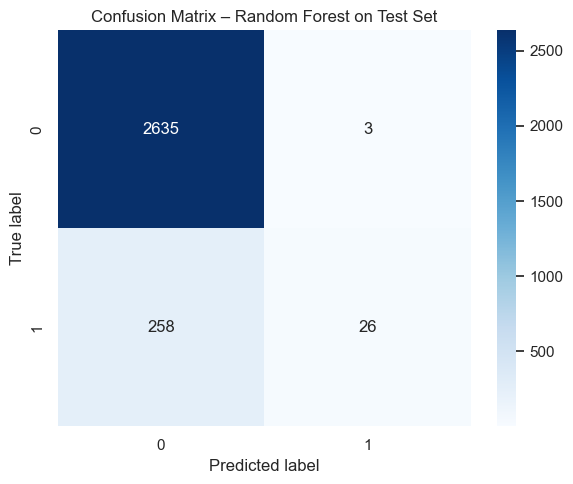

In [7]:
# ----------------------------------------------------------------------------
# 6. CONFUSION MATRIX – ERROR BREAKDOWN
# ----------------------------------------------------------------------------
# Purpose (business):
#   Translate the performance metrics into actual customer counts so that
#   the marketing / retention team can understand the operational impact.
#
# Interpretation:
#   - True Negatives  (top-left): correctly predicted non-churners.
#   - False Positives (top-right): predicted churn but actually stayed
#       -> these customers might receive unnecessary retention offers.
#   - False Negatives (bottom-left): predicted stay but actually churned
#       -> revenue risk; these are missed opportunities.
#   - True Positives  (bottom-right): correctly identified churners
#       -> key group for targeted interventions.
# ----------------------------------------------------------------------------

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True
)
plt.title("Confusion Matrix – Random Forest on Test Set")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

In [11]:
# ------------------------------------------------------------------------------------------------------------------
# Confusion Matrix - What does this mean for the business?
# -------------------------------------------------------------------------------------------------------------------
# This matrix breaks down how well the model classified customers into churners and non-churners.
#   
# Key insights:
  
# 2,635 customers were correctly classified as non-churners (true negatives).
# Only 3 customers were incorrectly flagged as churners (false positives), 
# which may lead to unnecessary retention actions but at a minor operational cost.

# 258 customers were incorrectly predicted to stay (false negatives) but actually churned
# this is the most concerning group, as we could lose these customers without any preventive action.

# 26 customers were correctly identified as churners (true positives), representing early detection of potential attrition.
      

# Implication:

# The model is highly accurate at identifying customers who will remain, which helps avoid unnecessary interventions. 
# However, it struggles to detect the majority of churners, which could still lead to avoidable revenue loss. 
# This highlights the need to further improve predictive recall, potentially through additional feature engineering, 
# alternative algorithm exploration, or threshold tuning.

# -----------------------------------------------------------------------------------------------------------------------

### 7. FEATURE IMPORTANCE - WHICH SIGNALS DRIVE THE PREDICTIONS?

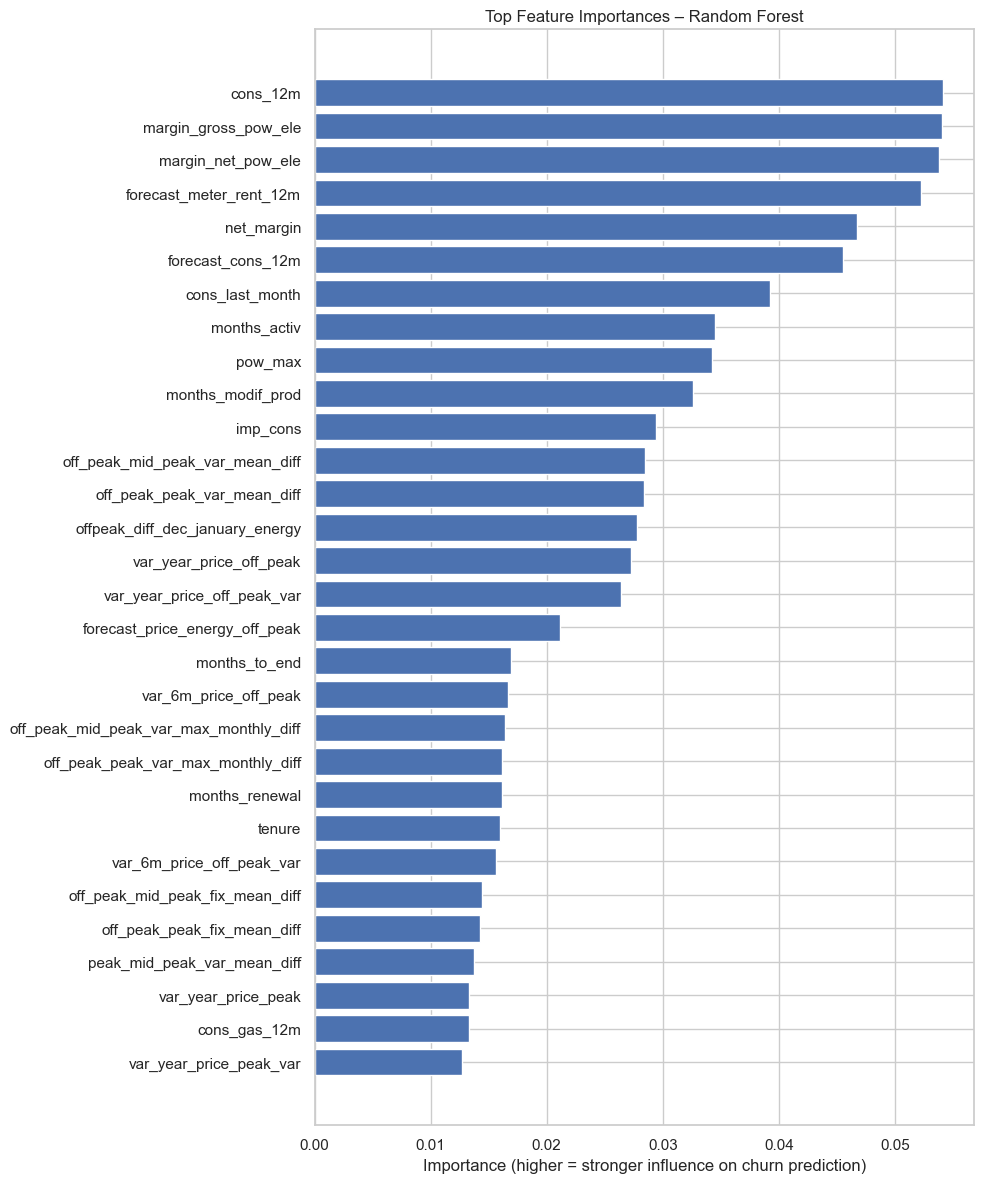

,feature,importance
0,cons_12m,0.0541
11,margin_gross_pow_ele,0.0541
12,margin_net_pow_ele,0.0538
5,forecast_meter_rent_12m,0.0522
14,net_margin,0.0467
3,forecast_cons_12m,0.0455
2,cons_last_month,0.0393
49,months_activ,0.0345
15,pow_max,0.0342
51,months_modif_prod,0.0326


In [8]:
# ----------------------------------------------------------------------------
# 7. FEATURE IMPORTANCE – WHICH SIGNALS DRIVE THE PREDICTIONS?
# ----------------------------------------------------------------------------
# Purpose (business):
#   Provide transparency on *why* the model behaves as it does.  This helps
#   stakeholders judge whether the model aligns with their domain knowledge
#   and informs future feature engineering.
#
# What this block does:
#   - Extracts the global feature importance from the trained Random Forest.
#   - Ranks features by importance.
#   - Plots a horizontal bar chart for the top 30 drivers of churn.
#     (Number can be adjusted if required.)
# ----------------------------------------------------------------------------

feature_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

TOP_N = 30
top_feats = feature_importances.head(TOP_N).sort_values("importance", ascending=True)

plt.figure(figsize=(10, 12))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.title("Top Feature Importances – Random Forest")
plt.xlabel("Importance (higher = stronger influence on churn prediction)")
plt.tight_layout()
plt.show()

display(feature_importances.head(10).style.format({"importance": "{:.4f}"}))

In [ ]:
# ------------------------------------------------------------------------------------------------------------------
# Top Influencing Drivers of Churn (Feature Importance)
# -------------------------------------------------------------------------------------------------------------------
# This analysis helps us understand which characteristics most strongly influence the model’s churn prediction.
#   
# - Consumption-related metrics (e.g., `cons_12m`, `margin_gross_pow_ele`) are consistently the most influential signals.
# - Profitability indicators such as `margin_gross_pow_ele`, `margin_net_pow_ele`, and 
#   customer net margin are also strong predictors.
# - Contract maturity and customer engagement (`months_activ`, `months_modif_prod`) also appear highly relevant, 
#   suggesting time-related behaviours drive churn.
# - Some price change sensitivity features and energy forecast pricing variables contributed, but did not dominate.

# This suggests that churn may be more strongly linked to customer usage patterns and financial relationships 
# than direct price sensitivity, partially aligning with initial hypotheses but indicating broader behavioural drivers.

# -----------------------------------------------------------------------------------------------------------------------

### 8. SCORING THE TEST SET - PROBABILITIES FOR BUSINESS USE

In [9]:
# ----------------------------------------------------------------------------
# 8. SCORING THE TEST SET – PROBABILITIES FOR BUSINESS USE
# ----------------------------------------------------------------------------
# Purpose (business):
#   Create a table that the business could use directly:
#     - one row per test-set customer,
#     - predicted churn label,
#     - churn probability (between 0 and 1).
#   This output can feed into a campaign tool where, for example, the top 5%
#   highest-risk customers receive a retention offer.
#
# What this block does:
#   - Computes churn probabilities using `predict_proba`.
#   - Assembles a concise scoring dataframe.
# ----------------------------------------------------------------------------

# Probabilities that each customer churns (class 1)
y_proba = rf.predict_proba(X_test)[:, 1]

scored_test = pd.DataFrame({
    "id": df.loc[X_test.index, "id"],          # keep ID for business join
    "churn_actual": y_test.values,
    "churn_pred": y_pred,
    "churn_proba": y_proba
})

display(scored_test.head())

,id,churn_actual,churn_pred,churn_proba
633,9dc24a7803c951a56697d7c2fc3cf815,0,0,0.078
8040,1899ebe335dd72b5ed94f6a7310eb02e,0,0,0.066
14584,85730a9de2afa781f2ab0694dfda2b91,0,0,0.148
5049,c1fa1e2b4d2235267c26e4c8de500a4f,0,0,0.072
12422,884f2029aca319d586b40744532ea519,0,0,0.066


In [15]:
# ------------------------------------------------------------------------------------------------------------------
# Final Model Performance Summary
# -------------------------------------------------------------------------------------------------------------------
# The Random Forest model demonstrates strong overall predictive accuracy (91.1%), 
# largely due to its ability to correctly identify customers who remain with the business. 
# Precision for churners is high (0.897), which means that when the model predicts churn, 
# it is usually correct, an important factor for efficient allocation of retention budget.
#
# However, the model currently achieves only 9.2% recall for churn cases, meaning it misses most customers 
# who are actually at risk of leaving. This presents a potential revenue risk, as undetected churners 
# may leave without any preventative action.
#
# In summary:
#
# | Metric | Score | Interpretation |
# |--------|-------|----------------|
# | Accuracy | 0.911 | Excellent overall hit-rate |
# | Precision | 0.897 | Low false alarms – good for cost control |
# | Recall | 0.092 | Very limited ability to catch churners |
# | F1 Score | 0.166 | Low combined effectiveness |
# 
# 
# Business Implications:
# - The model can be used confidently to avoid unnecessary retention offers.
# - It is **not yet suitable as the sole decision engine for churn intervention**, as most churners are missed. 
# - Improving churn recall will be essential. This may involve:
#   -Further feature engineering to capture risk behaviours
#   -Exploring model tuning or trialling alternative algorithms
#   -Adjusting decision thresholds or implementing a cost-sensitive evaluation strategy.

# -----------------------------------------------------------------------------------------------------------------------